##### データセットの場所やバッチサイズなどの定数値の設定

In [1]:
!git clone https://github.com/knakamura1982/AI_advanced.git

Cloning into 'AI_advanced'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 27 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (27/27), 65.10 KiB | 2.10 MiB/s, done.


In [2]:
%cd AI_advanced

/content/AI_advanced


In [3]:
# MLP_sample.ipynb 実行用
!mkdir -p MLP_models

# CNN_sample.ipynb 実行用
!mkdir -p CNN_models

# AE_sample_MNIST.ipynb 実行用
!mkdir -p AE_models_MNIST

# AE_sample_Face.ipynb 実行用
!mkdir -p AE_models_Face

# GAN_sample.ipynb 実行用
!mkdir -p GAN_models

# CVAE_sample.ipynb 実行用
!mkdir -p CVAE_models

# CGAN_sample.ipynb 実行用
!mkdir -p CGAN_models

# TL_sample.ipynb 実行用
!mkdir -p TL_models

# attention_sample.ipynb 実行用
!mkdir -p Att_models

# ViT_sample.ipynb 実行用
!mkdir -p ViT_models

# defacto_sample.ipynb 実行用
!mkdir -p defacto_models

# FakeFaces_sample.ipynb 実行用
!mkdir -p FakeFaces_models

In [4]:
import os

if not os.path.isdir('FakeFaces'):
    if not os.path.isfile('FakeFaces.tar.gz'):
        !wget "https://tus.box.com/shared/static/fzbje338p3lnf0gsencv1gozjgdtfr65.gz" -O FakeFaces.tar.gz
    !tar -xzvf FakeFaces.tar.gz
    !rm FakeFaces.tar.gz


ストリーミング出力は最後の 5000 行に切り捨てられました。
FakeFaces/train/real/03134.png
FakeFaces/train/real/03135.png
FakeFaces/train/real/03136.png
FakeFaces/train/real/03137.png
FakeFaces/train/real/03138.png
FakeFaces/train/real/03139.png
FakeFaces/train/real/03140.png
FakeFaces/train/real/03141.png
FakeFaces/train/real/03142.png
FakeFaces/train/real/03143.png
FakeFaces/train/real/03144.png
FakeFaces/train/real/03145.png
FakeFaces/train/real/03146.png
FakeFaces/train/real/03147.png
FakeFaces/train/real/03148.png
FakeFaces/train/real/03149.png
FakeFaces/train/real/03150.png
FakeFaces/train/real/03151.png
FakeFaces/train/real/03152.png
FakeFaces/train/real/03153.png
FakeFaces/train/real/03154.png
FakeFaces/train/real/03155.png
FakeFaces/train/real/03156.png
FakeFaces/train/real/03157.png
FakeFaces/train/real/03158.png
FakeFaces/train/real/03159.png
FakeFaces/train/real/03160.png
FakeFaces/train/real/03161.png
FakeFaces/train/real/03162.png
FakeFaces/train/real/03163.png
FakeFaces/train/real/03164.png
FakeFac

In [30]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'


# 使用するデバイス
# GPU を使用しない環境（CPU環境）で実行する場合は DEVICE = 'cpu' とする
DEVICE = 'cuda:0'

# 全ての訓練データを一回ずつ使用することを「1エポック」として，何エポック分学習するか
N_EPOCHS = 20

# 学習時のバッチサイズ
BATCH_SIZE = 100

# 訓練データセット（画像ファイルリスト）のファイル名
TRAIN_DATASET_CSV = './FakeFaces/train_list.csv'

# テストデータセット（画像ファイルリスト）のファイル名
TEST_DATASET_CSV = './FakeFaces/test_list.csv'

# 画像ファイルの先頭に付加する文字列（データセットが存在するディレクトリのパス）
DATA_DIR = './FakeFaces'

# 画像サイズ
H = 256 # 縦幅
W = 256 # 横幅
C = 3 # 入力画像のチャンネル数（カラー画像なら3，グレースケール画像なら1．なお，正解のマスク画像のチャンネル数は常に1）

# 学習結果の保存先フォルダ
MODEL_DIR = './FakeFaces_models'

# 学習結果のニューラルネットワークの保存先
MODEL_FILE = os.path.join(MODEL_DIR, 'fakeface_detector_model.pth')

##### ニューラルネットワークモデルの定義

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from mylib.basic_layers import DiscriminatorAugmentation


# 畳込み，バッチ正規化，ReLUをセットで行うクラス
class myConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(myConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
    def forward(self, x):
        return F.relu(self.bn(self.conv(x)))


# DeepFake Detection Challenge データセットの顔画像に対しReal/Fake判定を行うニューラルネットワーク
class FakeFaceDetector(nn.Module):

    # C: 入力画像のチャンネル数（1または3と仮定）
    # H: 入力画像の縦幅（32の倍数と仮定）
    # W: 入力画像の横幅（32の倍数と仮定）
    def __init__(self, C, H, W):
        super(FakeFaceDetector, self).__init__()

        # 畳込み層1〜5
        # カーネルサイズ3，ストライド幅1，パディング1の設定なので，これを通しても特徴マップの縦幅・横幅は変化しない
        self.conv1 = myConv2d(in_channels=C, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = myConv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv3 = myConv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = myConv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv5 = myConv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)

        # プーリング層1～5
        # 1回適用するごとに特徴マップの縦幅・横幅がそれぞれ 1/2 になる
        # 全部で5回適用することになるので，最終的には都合 1/32 になる -> ゆえに，入力画像の縦幅と横幅を各々32の倍数と仮定している
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        self.pool5 = nn.MaxPool2d(kernel_size=2)

        self.data_augment = transforms.RandomApply(torch.nn.ModuleList([
            transforms.RandomHorizontalFlip(p=0.1), # 確率0.5で左右反転
            #transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0), # カラージッター（明度を±20%，コントラストを±15%，彩度を±10%，色相を±5%の範囲内でランダムに変更）
            #transforms.RandomAffine(degrees=(-15, 15), scale=(0.8, 1.2)), # -15度〜15度の範囲でランダムに回転，さらに80%〜120%の範囲内でランダムにスケーリング
            transforms.RandomErasing(p=0.0), # 確率0.5で一部を消去
        ]), p=0.5)


        # 平坦化
        self.flat = nn.Flatten()

        # 全結合層1
        # 畳込み層1～5を通すことにより特徴マップの縦幅・横幅は都合 1/32 になっている．
        # 従って，入力側のパーセプトロン数は 64*(H/32)*(W/32) = H*W/16
        self.fc1 = nn.Linear(in_features=H*W//16, out_features=256)

        # 全結合層2
        self.fc2 = nn.Linear(in_features=256, out_features=2) # 最後はRealかFakeかの2クラス

    def forward(self, x, testmode=False):
        if not testmode:
            x = self.data_augment(x)
        h = self.pool1(self.conv1(x))
        h = self.pool2(self.conv2(h))
        h = self.pool3(self.conv3(h))
        h = self.pool4(self.conv4(h))
        h = self.pool5(self.conv5(h))
        h = self.flat(h)
        h = F.relu(self.fc1(h))
        y = self.fc2(h)
        return y

##### 訓練データセットの読み込み

In [82]:
import pickle
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from mylib.data_io import CSVBasedDataset


# CSVファイルを読み込み, 訓練データセットを用意
dataset = CSVBasedDataset(
    filename = TRAIN_DATASET_CSV,
    items = [
        'File Path', # X
        'Label' # Y
    ],
    dtypes = [
        'image', # Xの型
        'label'  # Yの型
    ],
    dirname = DATA_DIR
)
with open(os.path.join(MODEL_DIR, 'fdicts.pkl'), 'wb') as fdicts_file:
    pickle.dump(dataset.forward_dicts, fdicts_file)

# 訓練データセットを分割し，一方を検証用に回す
dataset_size = len(dataset)
valid_size = int(0.01 * dataset_size) # 全体の 1% を検証用に
train_size = dataset_size - valid_size # 残りの 99% を学習用に
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# 訓練データおよび検証用データをミニバッチに分けて使用するための「データローダ」を用意
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

##### 学習処理の実行

Epoch 1:


100%|██████████| 68/68 [00:23<00:00,  2.84it/s]


train loss = 0.638651


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


valid loss = 0.529135
accuracy = 75.00%

Epoch 2:


100%|██████████| 68/68 [00:23<00:00,  2.86it/s]


train loss = 0.481497


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


valid loss = 0.430150
accuracy = 76.47%

Epoch 3:


100%|██████████| 68/68 [00:24<00:00,  2.81it/s]


train loss = 0.420021


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


valid loss = 0.404196
accuracy = 80.88%

Epoch 4:


100%|██████████| 68/68 [00:23<00:00,  2.89it/s]


train loss = 0.367112


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


valid loss = 0.399274
accuracy = 79.41%

Epoch 5:


100%|██████████| 68/68 [00:23<00:00,  2.84it/s]


train loss = 0.306720


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


valid loss = 0.396793
accuracy = 86.76%

Epoch 6:


100%|██████████| 68/68 [00:23<00:00,  2.87it/s]


train loss = 0.259078


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


valid loss = 0.348424
accuracy = 86.76%

Epoch 7:


100%|██████████| 68/68 [00:24<00:00,  2.83it/s]


train loss = 0.219241


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


valid loss = 0.274029
accuracy = 86.76%

Epoch 8:


100%|██████████| 68/68 [00:23<00:00,  2.84it/s]


train loss = 0.203409


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


valid loss = 0.301971
accuracy = 89.71%

Epoch 9:


100%|██████████| 68/68 [00:23<00:00,  2.85it/s]


train loss = 0.181082


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


valid loss = 0.389073
accuracy = 86.76%

Epoch 10:


100%|██████████| 68/68 [00:23<00:00,  2.85it/s]


train loss = 0.150241


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


valid loss = 0.581912
accuracy = 86.76%

Epoch 11:


100%|██████████| 68/68 [00:23<00:00,  2.85it/s]


train loss = 0.121410


100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


valid loss = 0.347302
accuracy = 89.71%

Epoch 12:


100%|██████████| 68/68 [00:23<00:00,  2.83it/s]


train loss = 0.144999


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


valid loss = 0.470375
accuracy = 88.24%

Epoch 13:


100%|██████████| 68/68 [00:24<00:00,  2.79it/s]


train loss = 0.113929


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


valid loss = 0.457228
accuracy = 88.24%

Epoch 14:


100%|██████████| 68/68 [00:23<00:00,  2.84it/s]


train loss = 0.096891


100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


valid loss = 0.380471
accuracy = 89.71%

Epoch 15:


100%|██████████| 68/68 [00:23<00:00,  2.84it/s]


train loss = 0.093172


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


valid loss = 0.385430
accuracy = 88.24%

Epoch 16:


100%|██████████| 68/68 [00:23<00:00,  2.86it/s]


train loss = 0.088104


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


valid loss = 0.827659
accuracy = 79.41%

Epoch 17:


100%|██████████| 68/68 [00:24<00:00,  2.82it/s]


train loss = 0.064936


100%|██████████| 1/1 [00:00<00:00,  4.99it/s]


valid loss = 0.337570
accuracy = 89.71%

Epoch 18:


100%|██████████| 68/68 [00:23<00:00,  2.83it/s]


train loss = 0.038316


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


valid loss = 0.326694
accuracy = 91.18%

Epoch 19:


100%|██████████| 68/68 [00:23<00:00,  2.85it/s]


train loss = 0.041179


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


valid loss = 0.347926
accuracy = 92.65%

Epoch 20:


100%|██████████| 68/68 [00:23<00:00,  2.84it/s]


train loss = 0.077072


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


valid loss = 0.533003
accuracy = 88.24%



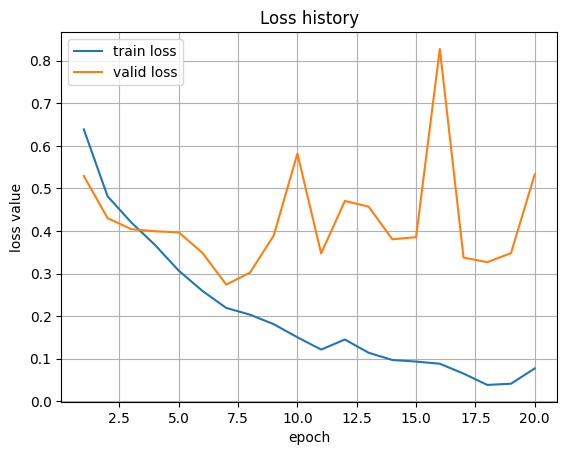

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from mylib.visualizers import LossVisualizer


# ニューラルネットワークの作成
model = FakeFaceDetector(C=C, H=H, W=W).to(DEVICE)

# 最適化アルゴリズムの指定（ここでは SGD でなく Adam を使用）
optimizer = optim.Adam(model.parameters())

# 損失関数
loss_func =  nn.CrossEntropyLoss()

# 損失関数値を記録する準備
loss_viz = LossVisualizer(['train loss', 'valid loss'])

# 勾配降下法による繰り返し学習
for epoch in range(N_EPOCHS):

    print('Epoch {0}:'.format(epoch + 1))

    # 学習
    model.train()
    sum_loss = 0
    for X, Y in tqdm(train_dataloader):
        for param in model.parameters():
            param.grad = None
        X = X.to(DEVICE) # 入力画像
        Y = Y.to(DEVICE) # RealかFakeかの2値ラベル
        Y_pred = model(X, testmode=True) # 入力画像 X をニューラルネットワークに入力し，RealかFakeかの判定値 Y_pred を得る
        loss = loss_func(Y_pred, Y) # 損失関数の現在値を計算
        loss.backward() # 誤差逆伝播法により，個々のパラメータに関する損失関数の勾配（偏微分）を計算
        optimizer.step() # 勾配に沿ってパラメータの値を更新
        sum_loss += float(loss) * len(X)
    avg_loss = sum_loss / train_size
    loss_viz.add_value('train loss', avg_loss) # 訓練データに対する損失関数の値を記録
    print('train loss = {0:.6f}'.format(avg_loss))

    # 検証
    model.eval()
    sum_loss = 0
    n_failed = 0
    with torch.inference_mode():
        for X, Y in tqdm(valid_dataloader):
            X = X.to(DEVICE) # 入力画像
            Y = Y.to(DEVICE) # RealかFakeかの2値ラベル
            Y_pred = model(X)
            loss = loss_func(Y_pred, Y)
            sum_loss += float(loss) * len(X)
            n_failed += torch.count_nonzero(torch.argmax(Y_pred, dim=1) - Y) # 判定結果と正解が一致していないデータの個数を数える
    avg_loss = sum_loss / valid_size
    loss_viz.add_value('valid loss', avg_loss) # 検証用データに対する損失関数の値を記録
    accuracy = (valid_size - n_failed) / valid_size
    print('valid loss = {0:.6f}'.format(avg_loss))
    print('accuracy = {0:.2f}%'.format(100 * accuracy))
    print('')

# 学習結果のニューラルネットワークモデルをファイルに保存
model = model.to('cpu')
torch.save(model.state_dict(), MODEL_FILE)

# 損失関数の記録をファイルに保存
loss_viz.save(v_file=os.path.join(MODEL_DIR, 'loss_graph.png'), h_file=os.path.join(MODEL_DIR, 'loss_history.csv'))

##### 学習済みニューラルネットワークモデルのロード

In [84]:
import torch


# ニューラルネットワークモデルとその学習済みパラメータをファイルからロード
model = FakeFaceDetector(C=C, H=H, W=W)
model.load_state_dict(torch.load(MODEL_FILE))

<All keys matched successfully>

##### テストデータセットの読み込み

In [85]:
from torch.utils.data import DataLoader
from mylib.data_io import CSVBasedDataset


# CSVファイルを読み込み, テストデータセットを用意
with open(os.path.join(MODEL_DIR, 'fdicts.pkl'), 'rb') as fdicts_file:
    fdicts = pickle.load(fdicts_file)
test_dataset = CSVBasedDataset(
    filename = TEST_DATASET_CSV,
    items = [
        'File Path', # X
        'Label' # Y
    ],
    dtypes = [
        'image', # Xの型
        'label'  # Yの型
    ],
    dirname = DATA_DIR,
    fdicts = fdicts
)
test_size = len(test_dataset)

# テストデータをミニバッチに分けて使用するための「データローダ」を用意
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

##### テスト処理

In [86]:
import torch


model = model.to(DEVICE)
model.eval()

# テストデータセットを用いて判定精度を評価
n_failed = 0
with torch.inference_mode():
    for X, Y in tqdm(test_dataloader):
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)
        Y_pred = model(X, testmode=True)
        n_failed += torch.count_nonzero(torch.argmax(Y_pred, dim=1) - Y) # 推定値と正解値が一致していないデータの個数を数える
    accuracy = (test_size - n_failed) / test_size
    print('accuracy = {0:.2f}%'.format(100 * accuracy))
    print('')

100%|██████████| 9/9 [00:02<00:00,  3.73it/s]

accuracy = 70.17%

